In [1]:
%cd ..

C:\Users\efurst1\PycharmProjects\LIDC_GDRO


In [70]:
%load_ext autoreload
%autoreload 2

In [71]:
import data_util
import models
import torch
import loss
import train
import pandas as pd
import numpy as np

In [72]:
device = "cuda" if torch.cuda.is_available() else "cpu"

training_fraction = 0.8
batch_size = 160
proportional = True

is_gdro = True

hparams = {"groupdro_eta": 0.0}

In [73]:
subtype_df = pd.read_csv("data/lidc_spic_subgrouped_radiologist.csv")

# import data
df = pd.read_csv("data/LIDC_individual_radiologists.csv")
# preprocess data (normalization, remove anything that isn't in the chosen features)
df = data_util.preprocess_data(df)

In [74]:
sum(df["malignancy"] == 0) / len(df)

0.6133909287257019

In [75]:
# get train/test flags
train_test = pd.read_csv("data/lidc_train_test_radiologist.csv")

# create train/test dataframes
training_df = df[df["noduleID"].isin(train_test[train_test["dataset"] == "train"]["noduleID"].values)]
test_df = df[df["noduleID"].isin(train_test[train_test["dataset"] == "test"]["noduleID"].values)]

# use noduleIDs as index, it makes things easier
subtype_df.index = subtype_df["noduleID"].values

# Test convergence of combinations of ERM and GDRO

In [81]:
N = 1
epochs = 2
subtypes = ["Overall", "Unspiculated benign", "Spiculated benign", "Spiculated malignant", "Unspiculated malignant"]

# test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth", "Adaptive"]
test_algorithms = ["ERM", "GDRO"]

results = {algorithm: np.zeros(N * epochs * len(subtypes)) for algorithm in test_algorithms}
for algorithm in test_algorithms:

    print("Running test: " + algorithm)

    # create the training and testing dataloaders
    if algorithm == "ERM":
        train_dataloader = data_util.create_dataloader(training_df, batch_size)
    else:
        train_dataloader = data_util.create_subtyped_dataloader(training_df, subtype_df, batch_size, proportional)
    test_dataloader = data_util.create_subtyped_dataloader(test_df, subtype_df, batch_size, proportional)

    for n in range(N):

        print(f"Trial {n + 1}/{N}")

        # create and train model
        model = models.NeuralNetwork(64, 32, 32, 2)
        model.to(device)

        if (algorithm == "ERM"):
            loss_fn = loss.ERMLoss(model, torch.nn.CrossEntropyLoss(), hparams)
        elif (algorithm == "GDRO"):
            loss_fn = loss.GDROLossAlt(model, torch.nn.CrossEntropyLoss(), hparams["groupdro_eta"], 4, rescale=True)
        else:
            loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, normalize_loss=True)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)

        for epoch in range(epochs):
            if algorithm == "Sharp":
                loss_fn.t = epoch / epochs < 0.5  # sharp boundary
            elif algorithm == "Smooth":
                loss_fn.t = 1 - (epoch / (epochs - 1))  # linear interpolation
            elif algorithm == "ReverseSmooth":
                loss_fn.t = epoch / (epochs - 1)  # reverse linear interpolation
            elif algorithm == "Adaptive":
                acc = train.test(test_dataloader, model)[0]
                loss_fn.t = acc < 0.85  # use gdro when overall accuracy is above threshold
            elif algorithm == "ExtraERM":
                loss_fn.t = 2
            elif algorithm == "ExtraGDRO":
                loss_fn.t = -1
                
            train.train(train_dataloader, model, loss_fn, optimizer)
            sensitivities = train.test(test_dataloader, model)
            
            for i in range(len(subtypes)):
                results[algorithm][n * epochs * len(subtypes) + epoch * len(subtypes) + i] = sensitivities[i]

results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

print("Test complete")

Running test: ERM
Trial 1/1
Running test: GDRO
Trial 1/1


ValueError: too many values to unpack (expected 3)

In [58]:
trial_means = results_df.unstack().unstack().mean().unstack(level=0).unstack(level=1).stack()
trial_means

ERM      GDRO
subtype                epoch                    
Overall                0      0.791748  0.798289
                       1      0.812679  0.808654
                       2      0.817358  0.815069
                       3      0.820176  0.812252
                       4      0.826013  0.812704
                       5      0.829635  0.816881
                       6      0.835371  0.817258
                       7      0.838642  0.818818
                       8      0.839447  0.824830
                       9      0.841610  0.825107
Spiculated benign      0      0.853667  0.882000
                       1      0.889667  0.899333
                       2      0.886333  0.910667
                       3      0.873667  0.901667
                       4      0.869000  0.889333
                       5      0.858667  0.885333
                       6      0.868000  0.878000
                       7      0.860333  0.882333
                       8      0.847333  0.881333
                       9      0.852667  0.880000
Spiculated malignant   0      0.783778  0.750111
                       1      0.803000  0.777000
                       2      0.807444  0.794556
                       3      0.825889  0.789556
                       4      0.841111  0.790333
                       5      0.851778  0.808667
                       6      0.857222  0.816222
                       7      0.872778  0.814889
                       8      0.871778  0.826778
                       9      0.889222  0.837667
Unspiculated benign    0      0.872744  0.905116
                       1      0.889907  0.908093
                       2      0.887256  0.904651
                       3      0.885209  0.900605
                       4      0.883023  0.901628
                       5      0.879163  0.898279
                       6      0.881349  0.894000
                       7      0.879907  0.894884
                       8      0.878140  0.893209
                       9      0.874326  0.891442
Unspiculated malignant 0      0.494880  0.460000
                       1      0.524000  0.468640
                       2      0.558080  0.490560
                       3      0.562560  0.498080
                       4      0.587520  0.502240
                       5      0.613440  0.515840
                       6      0.630080  0.525600
                       7      0.637120  0.532320
                       8      0.656000  0.559680
                       9      0.655200  0.552480

In [69]:
loss.GDROLoss??

In [59]:
worst_group = trial_means.unstack(level=1).min().unstack(level=0)
worst_group.index = pd.MultiIndex.from_product([["Worst"], worst_group.index], names=["subtype", "epoch"])
worst_concat = pd.concat([trial_means.unstack(level=1).stack(), worst_group])
worst_concat

ERM      GDRO
subtype                epoch                    
Overall                0      0.791748  0.798289
                       1      0.812679  0.808654
                       2      0.817358  0.815069
                       3      0.820176  0.812252
                       4      0.826013  0.812704
                       5      0.829635  0.816881
                       6      0.835371  0.817258
                       7      0.838642  0.818818
                       8      0.839447  0.824830
                       9      0.841610  0.825107
Spiculated benign      0      0.853667  0.882000
                       1      0.889667  0.899333
                       2      0.886333  0.910667
                       3      0.873667  0.901667
                       4      0.869000  0.889333
                       5      0.858667  0.885333
                       6      0.868000  0.878000
                       7      0.860333  0.882333
                       8      0.847333  0.881333
                       9      0.852667  0.880000
Spiculated malignant   0      0.783778  0.750111
                       1      0.803000  0.777000
                       2      0.807444  0.794556
                       3      0.825889  0.789556
                       4      0.841111  0.790333
                       5      0.851778  0.808667
                       6      0.857222  0.816222
                       7      0.872778  0.814889
                       8      0.871778  0.826778
                       9      0.889222  0.837667
Unspiculated benign    0      0.872744  0.905116
                       1      0.889907  0.908093
                       2      0.887256  0.904651
                       3      0.885209  0.900605
                       4      0.883023  0.901628
                       5      0.879163  0.898279
                       6      0.881349  0.894000
                       7      0.879907  0.894884
                       8      0.878140  0.893209
                       9      0.874326  0.891442
Unspiculated malignant 0      0.494880  0.460000
                       1      0.524000  0.468640
                       2      0.558080  0.490560
                       3      0.562560  0.498080
                       4      0.587520  0.502240
                       5      0.613440  0.515840
                       6      0.630080  0.525600
                       7      0.637120  0.532320
                       8      0.656000  0.559680
                       9      0.655200  0.552480
Worst                  0      0.494880  0.460000
                       1      0.524000  0.468640
                       2      0.558080  0.490560
                       3      0.562560  0.498080
                       4      0.587520  0.502240
                       5      0.613440  0.515840
                       6      0.630080  0.525600
                       7      0.637120  0.532320
                       8      0.656000  0.559680
                       9      0.655200  0.552480

In [60]:
"""
Test parameters

input: 64 engineered features extracted from lidc max-slice images

model layer sizes = (64, 32, 32, 2)
groupdro_eta = 0.1
lr = 0.001
weight_decay = 0.005

batch_size = 40
proportional = True
epochs = 40
N = 120

"""

'\nTest parameters\n\ninput: 64 engineered features extracted from lidc max-slice images\n\nmodel layer sizes = (64, 32, 32, 2)\ngroupdro_eta = 0.1\nlr = 0.001\nweight_decay = 0.005\n\nbatch_size = 40\nproportional = True\nepochs = 40\nN = 120\n\n'

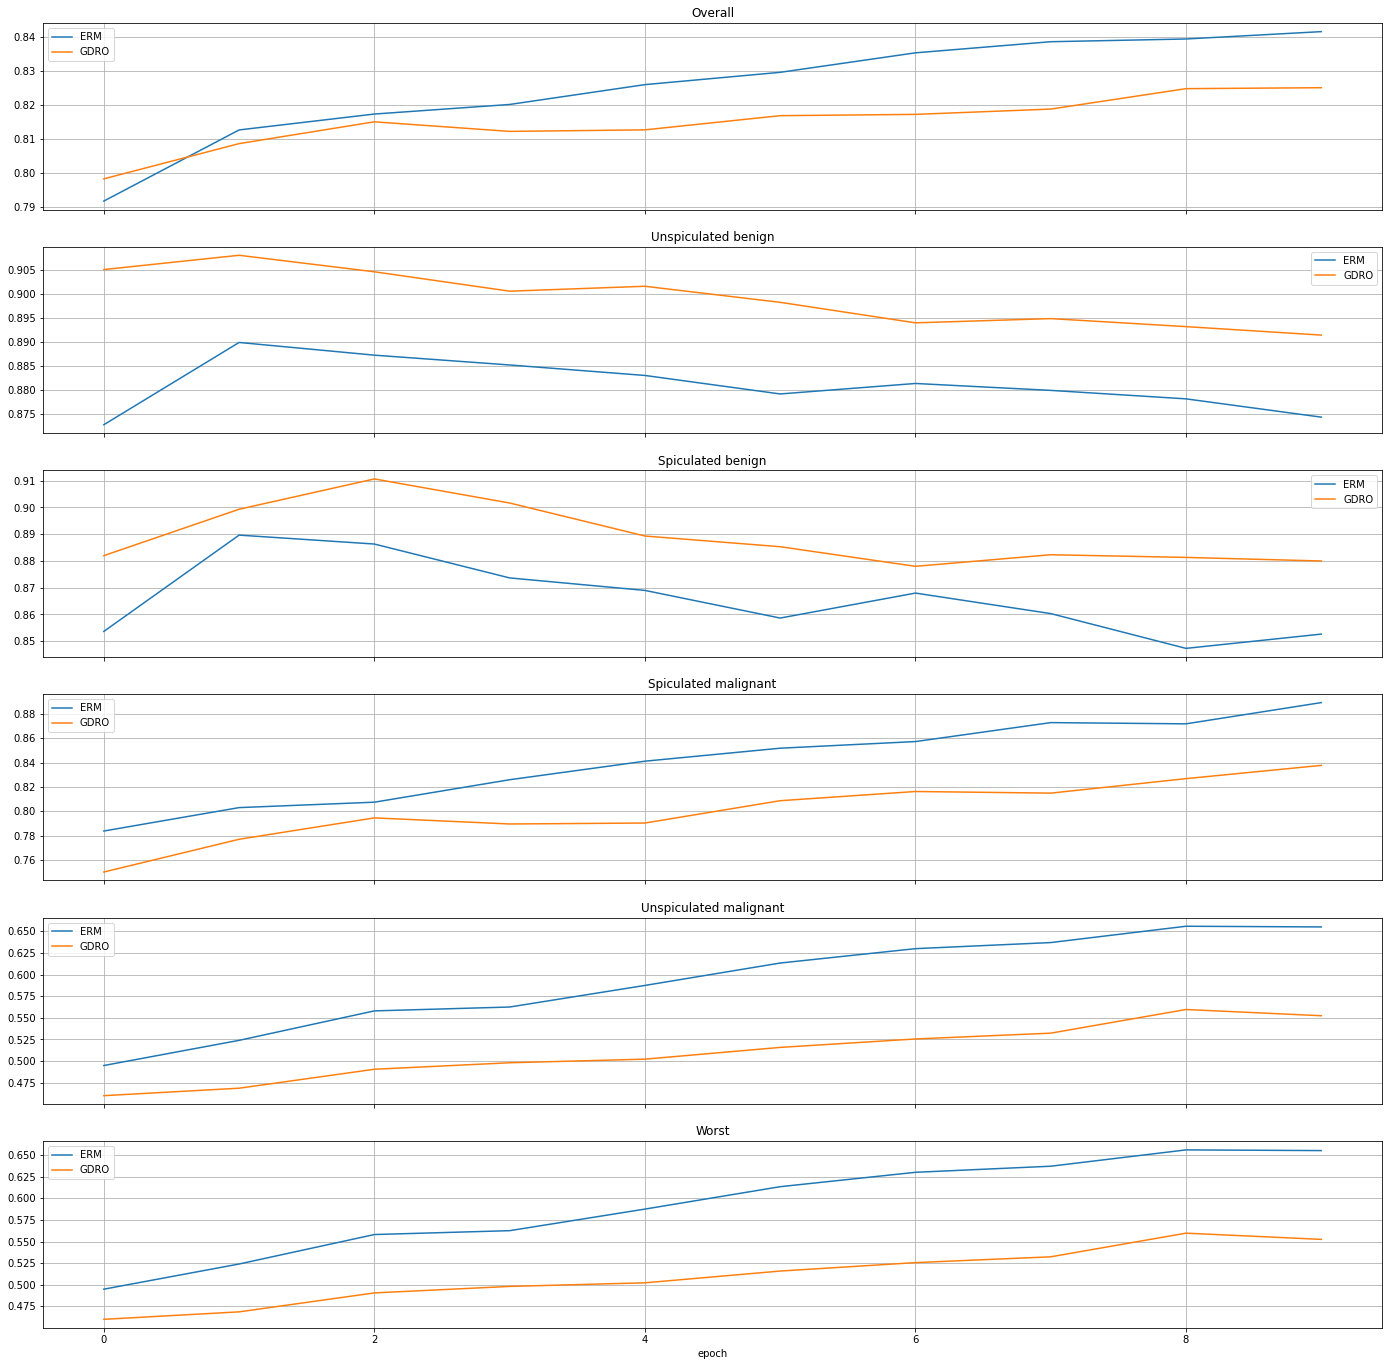

In [61]:
import matplotlib.pyplot as plt

rolling_window = 1

plots = [*subtypes, "Worst"]

f, a = plt.subplots(len(plots),1, sharex = True)
# plot subtypes sensitivity
for i in range(len(plots)):
    worst_concat.rolling(rolling_window).mean().xs(plots[i]).plot(kind='line',title=plots[i],ax=a[i],figsize=(24,24),grid=True)
    
# plot worst-group sensitivity
#for a in test_algorithms:
    #worst_group.rolling(rolling_window).mean().plot(title="Worst group")

In [88]:
from scipy.stats import ttest_ind
import statistics

# group_names = ["Overall", "GE MEDICAL SYSTEMS", "Unknown", "SIEMENS", "TOSHIBA", "Philips"]
group_names = ["Overall", "unmarked_benign", "marked_benign", "marked_malignant", "unmarked_malignant"]
# group_names = ["Overall", "0benign", "1benign", "0malignant", "1malignant"]
for i in range(5):
    print(group_names[i])
#     print(f"Mean ERM accuracy: {statistics.mean(data_clean[i]['ERM'])}")
#     print(f"Mean GDRO accuracy: {statistics.mean(data_clean[i]['GDRO'])}")
#     print(f"Mean Combined accuracy: {statistics.mean(data_clean[i]['Combined'])}")
    print(f"Mean Sharp accuracy: {statistics.mean(data_clean[i]['Sharp'])}")
    print(f"Mean Smooth accuracy: {statistics.mean(data_clean[i]['Smooth'])}")
    stat, p = ttest_ind(data_clean[i]["Sharp"], data_clean[i]["Smooth"])
    if p < 0.05:
        print(f"{'Sharp' if stat > 0 else 'Smooth'} higher accuracy (p = {p})")
    else:
        print(f"No statistically significant difference (p = {p})")
    print()
    

Overall


TypeError: 'numpy.float64' object is not iterable

In [ ]:
# old results with flawed malignancy labels + CNN subtypes
data_clean0